In [4]:
import tensorflow as tf
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization,Activation,GlobalAveragePooling2D
from keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2
from PIL import Image

In [5]:
from keras.utils.vis_utils import plot_model
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3

In [33]:
parasitized=os.listdir('cell_images/Parasitized')
uninfected=os.listdir('cell_images/Uninfected')

In [34]:
data=[]
labels=[]

for a in parasitized:
    try:
        image=cv2.imread("cell_images/Parasitized/"+a)
        image_from_array=Image.fromarray(image,'RGB')
        size_image=image_from_array.resize((140,140))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")
  

In [35]:
for b in uninfected:
    try:
        image=cv2.imread("cell_images/Uninfected/"+b)
        image_from_array=Image.fromarray(image,'RGB')
        size_image=image_from_array.resize((140,140))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

In [36]:
cells = np.array(data)
labels = np.array(labels)

np.save('Cells_140' , cells)
np.save('Labels_140' , labels)

In [6]:
cells=np.load('Cells_140.npy')
labels=np.load('Labels_140.npy')

In [7]:
n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]

In [8]:
from sklearn.model_selection import train_test_split

train_x , x , train_y , y = train_test_split(cells , labels , 
                                            test_size = 0.2 ,
                                            random_state = 111)

eval_x , test_x , eval_y , test_y = train_test_split(x , y , 
                                                    test_size = 0.5 , 
                                                    random_state = 111)

In [6]:
train_x.shape

(22046, 140, 140, 3)

In [9]:
train_x = train_x.astype('float32')
eval_x = eval_x.astype('float32')
test_x = test_x.astype('float32')

 # preprocess data
train_x = train_x / 255.0
eval_x = eval_x / 255.0
test_x= test_x /255.0

In [10]:
train_x.shape

(22046, 140, 140, 3)

In [11]:
img_rows=140
img_cols=140
num_classes=2
epochs = 10
batch_size = 128

In [12]:
if K.image_data_format() == 'channels_first':
    train_x = train_x.reshape(train_x.shape[0], 3, img_rows, img_cols)
    test_x = test_x.reshape(test_x.shape[0], 3, img_rows, img_cols)
    eval_x = eval_x.reshape(eval_x.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    train_x = train_x.reshape(train_x.shape[0], img_rows, img_cols, 3)
    eval_x = eval_x.reshape(eval_x.shape[0], img_rows, img_cols, 3)
    test_x = test_x.reshape(test_x.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

In [13]:
test_y1=test_y
test_y1

array([0, 1, 1, ..., 0, 1, 1])

In [14]:
train_y = keras.utils.to_categorical(train_y, 2)
test_y = keras.utils.to_categorical(test_y, 2)
eval_y = keras.utils.to_categorical(eval_y, 2)

In [15]:
num_classes=len(np.unique(labels))
num_classes

2

In [16]:
from keras import regularizers

In [17]:
inception=InceptionV3(include_top=False,weights='imagenet',input_shape=(140,140,3))
print(inception.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 140, 140, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 69, 69, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 69, 69, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 69, 69, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [18]:
from keras.layers import Input, Flatten, Dense
from keras.models import Model

In [19]:
# Freeze the layers 
for layer in inception.layers:
    layer.trainable = False
 
#Check the trainable status of the individual layers
for layer in inception.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x0000017E2FC94208> False
<keras.layers.convolutional.Conv2D object at 0x0000017E2FC94C88> False
<keras.layers.normalization.BatchNormalization object at 0x0000017E2FC943C8> False
<keras.layers.core.Activation object at 0x0000017E907C9320> False
<keras.layers.convolutional.Conv2D object at 0x0000017E90B63160> False
<keras.layers.normalization.BatchNormalization object at 0x0000017E0003EE48> False
<keras.layers.core.Activation object at 0x0000017E0FA9D080> False
<keras.layers.convolutional.Conv2D object at 0x0000017E0FB1F9B0> False
<keras.layers.normalization.BatchNormalization object at 0x0000017E0FAF1B00> False
<keras.layers.core.Activation object at 0x0000017E0FE726D8> False
<keras.layers.pooling.MaxPooling2D object at 0x0000017E0FEB6AC8> False
<keras.layers.convolutional.Conv2D object at 0x0000017E0FE93F60> False
<keras.layers.normalization.BatchNormalization object at 0x0000017E0FEF0860> False
<keras.layers.core.Activation object at 0x000

In [20]:
add_model = Sequential()
add_model.add(inception)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(2, 
                    activation='softmax',kernel_regularizer=regularizers.l2(1e-4)))

model = add_model

In [21]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________
None


In [23]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=1e-4,clipnorm=0.5),
              metrics=['accuracy'])
history=model.fit(train_x, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(eval_x, eval_y))
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.
score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train on 22046 samples, validate on 2756 samples
Epoch 1/10
22046/22046 [==============================] - 41s 2ms/step - loss: 0.3128 - acc: 0.8821 - val_loss: 0.3410 - val_acc: 0.8683
Epoch 2/10
22046/22046 [==============================] - 37s 2ms/step - loss: 0.3115 - acc: 0.8801 - val_loss: 0.3449 - val_acc: 0.8654
Epoch 3/10
22046/22046 [==============================] - 37s 2ms/step - loss: 0.3045 - acc: 0.8861 - val_loss: 0.3353 - val_acc: 0.8701
Epoch 4/10
22046/22046 [==============================] - 38s 2ms/step - loss: 0.3053 - acc: 0.8845 - val_loss: 0.3342 - val_acc: 0.8705
Epoch 5/10
22046/22046 [==============================] - 38s 2ms/step - loss: 0.3015 - acc: 0.8847 - val_loss: 0.3338 - val_acc: 0.8712
Epoch 6/10
22046/22046 [==============================] - 37s 2ms/step - loss: 0.2979 - acc: 0.8868 - val_loss: 0.3440 - val_acc: 0.8661
Epoch 7/10
22046/22046 [==============================] - 40s 2ms/step - loss: 0.2922 - acc: 0.8905 - val_loss: 0.3319 - val_acc:

In [24]:
def plot_loss_acc_curves(history):
# Loss Curves
  plt.figure(figsize=[8,6])
  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
# Accuracy Curves 
  plt.figure(figsize=[8,6])
  plt.plot(history.history['acc'],'r',linewidth=3.0)
  plt.plot(history.history['val_acc'],'b',linewidth=3.0)
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)

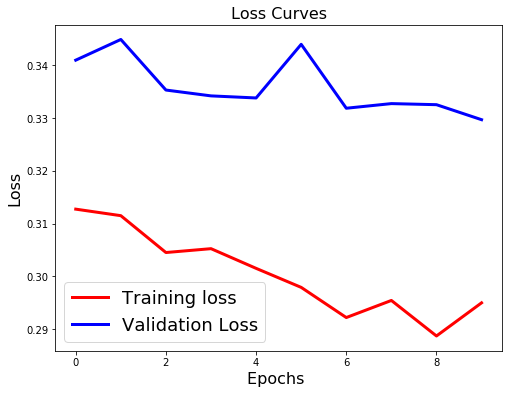

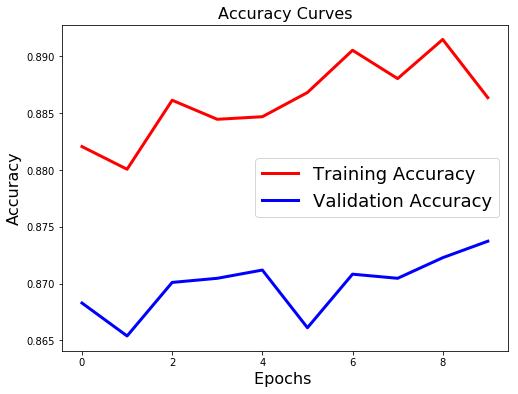

In [25]:
plot_loss_acc_curves(history)

In [26]:
# Save the model
model.save('inception.h5')

In [27]:
from keras.models import load_model
model=load_model('inception.h5')

In [28]:
classes=model.predict(test_x,batch_size=128)

In [29]:
y_classes = classes.argmax(axis=-1)
y_classes

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

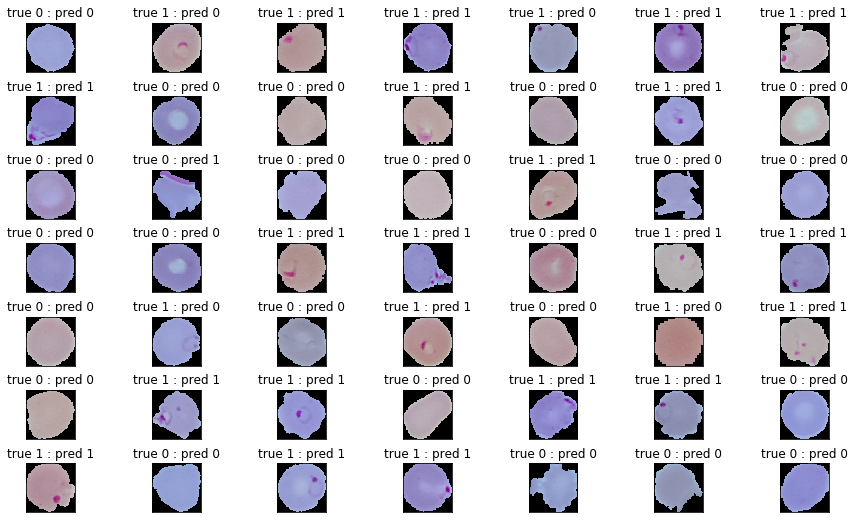

In [30]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint( 0  , test_x.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(test_x[r[0]])
    plt.title('true {} : pred {}'.format(test_y1[r[0]] , y_classes[r[0]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

In [31]:
from sklearn.metrics import confusion_matrix,classification_report

In [32]:
# confusion matrix
print("Confusin Matrix : ")
print(confusion_matrix(test_y1, y_classes))
print('.'*100)

# classification report
print("Classification Report : ")
print(classification_report(test_y1, y_classes))

Confusin Matrix : 
[[1275  122]
 [ 260 1099]]
....................................................................................................
Classification Report : 
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1397
           1       0.90      0.81      0.85      1359

   micro avg       0.86      0.86      0.86      2756
   macro avg       0.87      0.86      0.86      2756
weighted avg       0.86      0.86      0.86      2756

